# Download a model from Azure Workspace, test it locally and deploy it as a REST Web service

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
import azureml.core

# display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.85


## Download model pickle file from Azure Workspace

In [2]:
from azureml.core import Workspace
from azureml.core.model import Model
import os 
ws = Workspace.from_config()
model=Model(ws, 'cancer_detector_SVM_rbf')

model.download(target_dir=os.getcwd(), exist_ok=True)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "model_svm_rbf.pkl")

os.stat(file_path)

os.stat_result(st_mode=33206, st_ino=14355223813344257, st_dev=1050226512, st_nlink=1, st_uid=0, st_gid=0, st_size=8097, st_atime=1582525877, st_mtime=1582525877, st_ctime=1582435061)

## Test the model locally

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

cell_df = pd.read_csv("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv")

cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')

feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)

cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)



In [4]:
import pickle
from sklearn.externals import joblib

clf = joblib.load( os.path.join(os.getcwd(), 'model_svm_rbf.pkl'))
yhat = clf.predict(X_test)
print(y_test)
print(yhat)

[2 4 2 4 2 2 2 2 4 2 2 4 4 4 4 2 2 2 2 2 4 2 4 4 2 2 2 2 4 4 4 2 4 2 2 2 4
 2 2 2 2 2 2 4 4 2 2 2 2 4 2 2 2 2 2 2 4 2 2 2 2 4 4 2 2 4 4 2 2 2 4 4 2 2
 2 4 2 2 2 4 2 2 2 2 4 4 2 4 2 2 2 4 2 2 2 4 2 2 2 4 2 4 2 2 4 2 4 2 2 4 2
 2 4 2 2 2 2 2 4 4 4 4 4 2 2 4 2 2 4 2 4 2 2 2 2 2 4]
[2 4 2 4 2 2 2 2 4 2 2 4 4 4 4 2 2 2 2 2 4 2 4 4 4 4 2 2 4 4 4 2 4 2 2 2 4
 2 2 2 2 2 2 4 4 2 2 2 2 4 2 2 2 2 2 2 4 2 2 2 2 4 4 2 4 4 4 2 2 2 4 4 2 2
 2 4 2 2 4 4 2 2 2 2 4 4 2 4 2 2 4 4 2 2 2 4 2 2 2 4 2 4 2 2 4 2 4 2 2 4 2
 2 4 2 2 2 2 2 4 4 4 4 4 2 2 4 2 2 4 2 4 2 2 2 2 2 4]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Plot the confusion Matrix

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools



In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


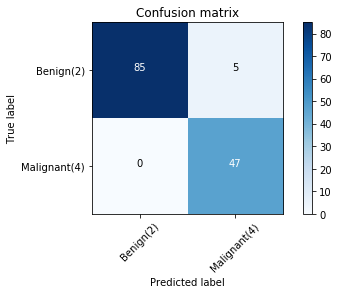

In [7]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

# Deploy as a Web service

In [8]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
import joblib

def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'model_svm_rbf.pkl')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Overwriting score.py


In [9]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_pip_package("scikit-learn==0.22.1")
myenv.add_pip_package("azureml-defaults")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [10]:
with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will

# be automatically provisioned for runs with userManagedDependencies=False.


# Details about the Conda environment file format:

# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually


name: project_environment
dependencies:
  # The python interpreter version.

  # Currently Azure ML only supports 3.5.2 and later.

- python=3.6.2

- pip:
  - scikit-learn==0.22.1
  - azureml-defaults
channels:
- conda-forge



In [11]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "CancerData",  "method" : "sklearn"}, 
                                               description='Cancer classification with sklearn')

In [14]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment


myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

service = Model.deploy(workspace=ws, 
                       name='cancer-detect-svc', 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Running................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Wall time: 7min 21s


## Test the newly deployed web service by consuming it with some sample data

In [17]:
import json

# find 10 random samples from test set
n = 10
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
print(test_samples)
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

print (result)

{"data": [[4, 1, 1, 1, 2, 1, 3, 1, 1], [6, 8, 7, 5, 6, 8, 8, 9, 2], [2, 1, 1, 1, 2, 1, 3, 1, 1], [6, 9, 7, 5, 5, 8, 4, 2, 1], [8, 10, 10, 10, 6, 10, 10, 10, 1], [10, 7, 7, 3, 8, 5, 7, 4, 3], [1, 1, 1, 1, 2, 1, 1, 1, 1], [7, 4, 5, 10, 2, 10, 3, 8, 2], [5, 1, 1, 1, 2, 1, 3, 1, 1], [1, 1, 1, 1, 2, 1, 3, 2, 1]]}
[2, 4, 2, 4, 4, 4, 2, 4, 2, 2]


In [16]:
service.get_logs()

'/bin/bash: /azureml-envs/azureml_6f08e13c48314c24cc18e55011b142fc/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n/bin/bash: /azureml-envs/azureml_6f08e13c48314c24cc18e55011b142fc/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n/bin/bash: /azureml-envs/azureml_6f08e13c48314c24cc18e55011b142fc/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n/bin/bash: /azureml-envs/azureml_6f08e13c48314c24cc18e55011b142fc/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n2020-02-24T06:39:26,150034776+00:00 - gunicorn/run \n2020-02-24T06:39:26,157932285+00:00 - iot-server/run \n2020-02-24T06:39:26,163468191+00:00 - rsyslog/run \n2020-02-24T06:39:26,163282491+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_6f08e13c48314c24cc18e55011b142fc/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_6f08e13c48314c24cc